In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "MIG-40f43250-998e-586a-ac37-d6520e92590f"

In [25]:
import numpy as np
import torch
import pyBigWig
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import sys
sys.path.append('../2_train_models')
from data_loading import read_fasta_fast, one_hot_encode
from file_configs import FoldFilesConfig, MergedFilesConfig

sys.path.append("../3_eval_models")
from eval_utils import model_predict_with_rc

import logomaker

In [3]:
# specify what set of models to look at
cell_type = "K562"

# the unique IDs for each of the folds / models in this cell type
timestamps = ["2023-05-29_15-51-40",
              "2023-05-29_15-58-41",
              "2023-05-29_15-59-09",
              "2023-05-30_01-40-06",
              "2023-05-29_23-21-23",
              "2023-05-29_23-23-45",
              "2023-05-29_23-24-11"]

# these usually don't change
model_type = "strand_merged_umap"
data_type = "procap"

# size of the model inputs and outputs
in_window = 2114
out_window = 1000

puffin_agg_plus_bw = "data/resources/agg.plus.allprocap.bedgraph.sorted.merged.bw"
puffin_agg_minus_bw = "data/resources/agg.minus.allprocap.bedgraph.sorted.merged.bw"

In [4]:
# these paths aren't specific to any model / fold, cell type, or data_type

# Load the config object for when model outputs were merged across all folds

merged_config = MergedFilesConfig(cell_type, model_type, data_type)

# these paths aren't specific to any model / fold, cell type, or data_type

proj_dir = merged_config.proj_dir
genome_path = merged_config.genome_path
chrom_sizes = merged_config.chrom_sizes

figures_dir = proj_dir + "figures/"
os.makedirs(figures_dir, exist_ok=True)

In [5]:
### Data Loading

def load_sequence_at_locus(chrom, start, end, genome_path):
    # load (forward strand) genomic sequence between start and end coords
    genome = read_fasta_fast(genome_path, include_chroms = [chrom])
    # seq is a string
    seq = genome[chrom][start:end]
    
    # one-hot encode the sequence string (returns numpy array)
    onehot_seq = one_hot_encode(seq).T
    
    # after transposing, onehot_seq is shape (4, end - start)
    return seq, onehot_seq


def load_observed_profile_at_locus(chrom, start, end, plus_bw_path, minus_bw_path):
    # load the positive-strand PRO-cap data between the start and end coords
    with pyBigWig.open(plus_bw_path, "r") as plus_bw:
        plus_sig = plus_bw.values(chrom, start, end, numpy=True)
    plus_sig = np.nan_to_num(plus_sig)

    # repeat for the negative strand
    with pyBigWig.open(minus_bw_path, "r") as minus_bw:
        minus_sig = minus_bw.values(chrom, start, end, numpy=True)
    minus_sig = np.nan_to_num(minus_sig)

    # combine into array of shape (2, end - start)
    signal = np.array([plus_sig, minus_sig])
    return signal


def get_locus_data(chrom, start, end, config,
                   in_window=in_window, out_window=out_window):
    # loads sequence and observed data, *centered* between start and end coords
    
    genome_path = config.genome_path
    plus_bw_path = puffin_agg_plus_bw
    minus_bw_path = puffin_agg_minus_bw
    
    # calculate sequence coordinates so they'll match model input size
    mid = (start + end) // 2
    seq_start = mid - in_window // 2
    seq_end = seq_start + in_window
    seq, onehot_seq = load_sequence_at_locus(chrom, seq_start, seq_end,
                                             genome_path)
    
    # calculate profile coordinates so they'll match model output size
    prof_start = mid - out_window // 2
    prof_end = prof_start + out_window
    prof = load_observed_profile_at_locus(chrom, prof_start, prof_end,
                                          plus_bw_path, minus_bw_path)
    
    return seq, onehot_seq, prof


# The example we will plot: MYC promoter coordinates
chrom, start, end = ["chr8", 127735875, 127736475]

# Load everything before doing any motif ablation (og = original)
og_seq, og_onehot_seq, og_prof = get_locus_data(chrom, start, end, merged_config)

Loading genome sequence from /mnt/lab_data2/kcochran/procapnet/genomes/hg38.withrDNA.fasta


Reading FASTA: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.96s/it]


In [6]:
# Load model

from puffin import *

puffin = Puffin(use_cuda=True)

In [7]:
def trim_seq_to_puffin_len(seq, puffin_len=1650):
    assert type(seq) == str, type(seq)
    
    to_trim_total = len(seq) - puffin_len
    assert to_trim_total % 2 == 0, to_trim_total
    
    to_trim_side = to_trim_total // 2
    
    trimmed = seq[to_trim_side : - to_trim_side]
    
    assert len(trimmed) == puffin_len, len(trimmed)
    return trimmed

def puffin_predict(seq, puffin_model):
    if len(seq) > 1650:
        seq = trim_seq_to_puffin_len(seq)
        
    raw_pred_df = puffin_model.predict(seq)
    
    # select for the PRO-cap + and - strands from all outputs
    pred = np.exp(np.array([np.array(raw_pred_df)[6],
                     np.array(raw_pred_df)[-1]]).astype(float)) - 1
    return pred

In [8]:
og_pred_prof = puffin_predict(og_seq, puffin)
# I closely checked and the prediction looks the same as the browser view does at this locus
og_pred_prof.shape

(2, 1000)

In [9]:
from tangermeme.ism import saturation_mutagenesis
from tangermeme.utils import one_hot_encode as tangermeme_ohe
from tqdm import tqdm

from collections import defaultdict


def reverse_ohe(seq_onehot):
    assert len(seq_onehot.shape) == 2 and seq_onehot.shape[0] == 4, seq_onehot.shape
    seq_onehot = seq_onehot.T
    
    ohe_to_str = defaultdict(lambda : "N")
    ohe_to_str[(1,0,0,0)] = "A"
    ohe_to_str[(0,1,0,0)] = "C"
    ohe_to_str[(0,0,1,0)] = "G"
    ohe_to_str[(0,0,0,1)] = "T"
    
    seq_str = "".join([ohe_to_str[tuple([int(num) for num in base])] for base in seq_onehot])
    return seq_str


class PuffinWrapperProcap(torch.nn.Module):
    def __init__(self, model):
        super(PuffinWrapperProcap, self).__init__()
        self.model = model

    def logits_to_a_number_deepshappy(self, logits):
        logits = torch.Tensor(logits).reshape(-1)
        mean_norm_logits = logits - torch.mean(logits, axis = -1, keepdims = True)
        softmax_probs = torch.nn.Softmax(dim=-1)(mean_norm_logits.detach())
        final = (mean_norm_logits * softmax_probs).sum(axis=-1)
        return final
    
    def logits_to_a_number(self, logits):
        pred = np.exp(logits)
        final = pred.sum()
        return final
        
    def forward_one_seq(self, seq):
        if type(seq) != str:
            seq = seq.squeeze()
            assert len(seq.shape) == 2, seq.shape
            seq = reverse_ohe(seq)

        all_preds = self.model.predict(seq)
        pred = np.array([np.array(all_preds)[6],
                         np.array(all_preds)[-1]]).astype(float)
        
        return self.logits_to_a_number(pred)
        
    def forward(self, X):
        # doesn't need to be differentiable if we just do ISM
        model_outputs = []
        for seq in X:
            model_outputs.append(self.forward_one_seq(seq))
        return torch.Tensor(np.array(model_outputs))

def puffin_ism(seq, puffin_model):
    seq_len = len(seq)
    if type(seq) == str:
        seq = tangermeme_ohe(seq).unsqueeze(0)

    wrapper = PuffinWrapperProcap(puffin_model)
    X_attr = saturation_mutagenesis(wrapper, seq,
                                    start = seq_len//2 - 500 + 457 - 225//2, end = seq_len//2 - 500 + 457 - 225//2 + 225,
                                    device='cuda', verbose=True)
    return X_attr

og_ism = puffin_ism(og_seq, puffin)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [01:42<00:00,  3.55s/it]


In [10]:
og_ism.shape

torch.Size([1, 4, 225])

findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font famil

findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font famil

findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font famil

findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font famil

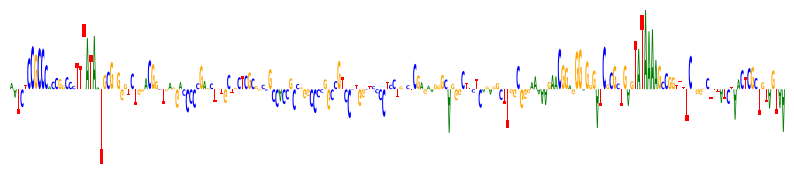

In [11]:
plt.figure(figsize=(10,2))
plot_motif_on_ax(og_ism.squeeze().T, plt.gca())
plt.show()

In [37]:
def plot_prof_on_ax(profile, ax, zoom_start, zoom_end,
                    color = "#001DAC", alphas = [1, 0.6],
                    linewidth=0.8, x_axis_buffer=0):
    
    # the + 0.5 is so the profiles are right on top of the bases of the scores
    x_range = np.arange(zoom_start, zoom_end) + 0.5
    
    # when both strands have data at 0, they'll plot on top of each other.
    # this offset is the minimum needed to uniformly add to the plotting
    # of both strands so that when the lines are at 0, they're both still visible
    offset = np.max(np.abs(profile[:, zoom_start:zoom_end])) * 0.02
    
    # plot positive strand
    ax.plot(x_range, profile[0, zoom_start:zoom_end] + offset,
            alpha = alphas[0], c = color, linewidth=linewidth)
    # plot negative strand
    ax.plot(x_range, -1 * profile[1, zoom_start:zoom_end] - offset,
            alpha = alphas[1], c = color, linewidth=linewidth)

    ax.set_xlim(zoom_start - x_axis_buffer, zoom_end + x_axis_buffer)
    
    
def get_prof_plot_lims(profs, zoom_start, zoom_end):
    # figure out what the range of the y-axis should be, so that
    # it includes the most extreme values in every profile we will plot
    
    pos_strand_max = 0
    neg_strand_max = 0
    
    # figure out the maximum across any profile, for each strand
    for prof in profs:
        pos_strand_max = max(pos_strand_max, np.max(prof[0, zoom_start:zoom_end]))
        neg_strand_max = max(neg_strand_max, np.max(prof[1, zoom_start:zoom_end]))
    
    return -1 * neg_strand_max, pos_strand_max 


def get_attr_plot_lims(attrs, zoom_start, zoom_end):
    # same as get_prof_plot_lims() but for the contribution score tracks
    
    # we don't have two strands, but values can be positive or negative
    pos_max = 0
    neg_max = 0
    
    for attr in attrs:
        pos_max = max(pos_max, torch.max(attr))
        neg_max = min(neg_max, torch.min(attr))
    return neg_max, pos_max 


def plot_motif_on_ax(array, ax):
    assert len(array.shape) == 2 and array.shape[-1] == 4, array.shape
    # reformat pwm to what logomaker expects
    df = pd.DataFrame(array, columns=['A', 'C', 'G', 'T'])
    df.index.name = 'pos'

    # plot motif ("baseline_width=0" removes the y=0 line)
    crp_logo = logomaker.Logo(df, ax=ax, font_name='Arial Rounded', baseline_width=0)
    
    # fix appearance to be less terrible
    crp_logo.style_spines(visible=False)
    #ax.spines[["top", "right", "bottom"]].set_visible(False)
    ax.set_ylim(min(df.sum(axis=1).min(), 0), df.sum(axis=1).max())
    ax.set_xticks([])
    ax.set_yticks([])
    
    return crp_logo

findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font famil

findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font famil

findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font famil

findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font family 'Arial Rounded' not found.
findfont: Font famil

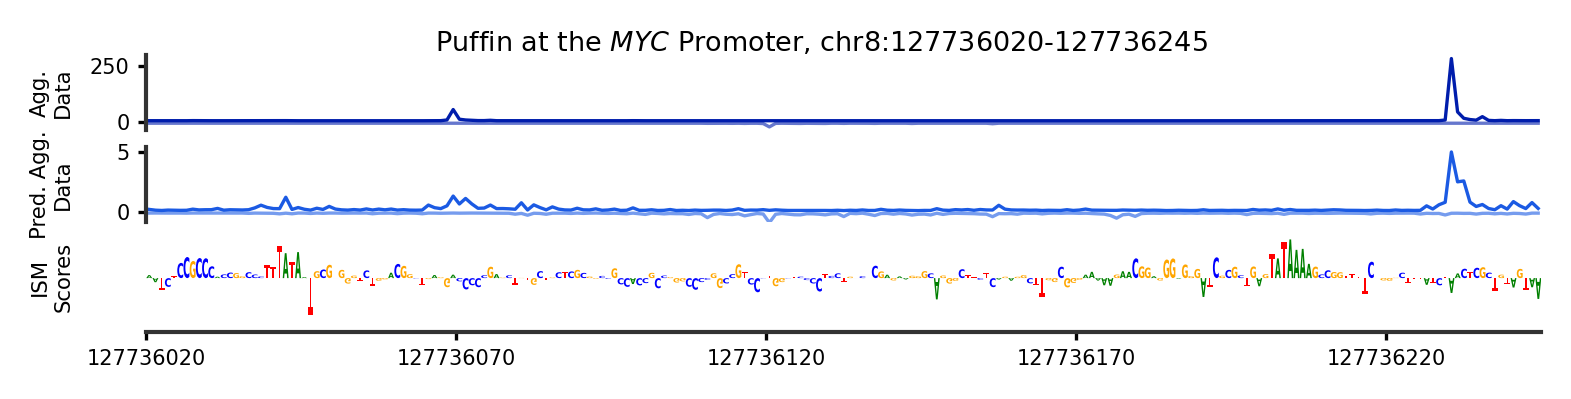

In [38]:
def plot_true_and_pred_prof_and_ism(og_seq, og_onehot_seq,
                                  true_profile, og_pred_profile, og_prof_attr,
                                  prof_len = out_window, save_path = None,
                                  zoom_midpoint = 457, zoom_width = 225):
    
    plot_params = {"xtick.labelsize": 8, "ytick.labelsize": 8}
    plt.rcParams.update(plot_params)
    axis_fontsize = 5.1
    axis_labelpad = 4
    axis_index = 0
    
    
    # total plot-rows: (original data, pred, and scores), and then (pred, scores) for each mutation
    num_subplots = 3
    
    # we will have an extra insivible thin row at the end for spacing
    num_actual_subplots = 3 + 1
    
    height_ratios = [100,100,100, 1]
    
    
    fig = plt.figure(figsize=(6, 0.4 * num_subplots), dpi=300)
    gs = fig.add_gridspec(num_actual_subplots, height_ratios = height_ratios, hspace=0.3)
    axes = gs.subplots()

    # use eyeballs to figure out what exact bases you want to plot
    # plto will show region that is (zoom_midpoint - zoom_width/2, zoom_midpoint + zoom_width/2)
    zoom_start = min(max(zoom_midpoint - zoom_width//2, 0), prof_len - zoom_width)
    zoom_end = zoom_start + zoom_width
    genomic_start = (start + end) // 2 - out_window // 2
    
    title = "Puffin at the " + r'$\it{MYC}$ Promoter, ' + chrom + ":" + str(genomic_start + zoom_start) + "-" + str(genomic_start + zoom_end)
    fig.suptitle(title, y = 0.95, fontsize=6.5, horizontalalignment='center')
    
    # figure out what you want the y-axis range of the predicted profiles to consistently be
    pred_prof_min, pred_prof_max = get_prof_plot_lims([og_pred_profile],
                                                      zoom_start, zoom_end)
    pred_prof_min = pred_prof_min * 1.1
    pred_prof_max = pred_prof_max * 1.1
    
    # all this nice generalizable code is no match for matplotlib choosing a weird-looking axis tick
    # sorry hardcoding the axis limit to look less dumb for MYC example
    if 200 - pred_prof_max < 10:
        pred_prof_max = 200
    
    # repeat for attributions
    attr_min, attr_max = get_attr_plot_lims([og_prof_attr],
                                            zoom_start, zoom_end)
    
    
    # plot original observed data
    
    plot_prof_on_ax(true_profile, axes[axis_index], zoom_start, zoom_end,
                    color = "#001DAC")
    
    axes[axis_index].set_ylabel("Agg.\nData", fontsize = axis_fontsize,
                                rotation=90, labelpad=axis_labelpad)
    axis_index += 1
    
    
    # plot original model prediction
    
    plot_prof_on_ax(og_pred_profile, axes[axis_index], zoom_start, zoom_end,
                    color = "#1B5AE3")
    
    axes[axis_index].set_ylabel("Pred. Agg.\nData", fontsize = axis_fontsize,
                                rotation=90, labelpad=axis_labelpad)
    axes[axis_index].set_ylim(pred_prof_min, pred_prof_max)
    axis_index += 1
    
    
    # plot original contribution scores
    
    plot_motif_on_ax(og_prof_attr.squeeze().T, axes[axis_index])
    
    axes[axis_index].set_ylabel("ISM\nScores",
                                fontsize = axis_fontsize, rotation=90,
                                labelpad=axis_labelpad)
    axes[axis_index].set_ylim(attr_min, attr_max)
        
    
    # aesthetics below
    
    xticks = np.arange(0, zoom_end - zoom_start, 50)
    xticklabels = np.array([int(tick_pos + zoom_start + genomic_start) for tick_pos in xticks])

    for ax_i, ax in enumerate(axes):
        ax.tick_params(length=2, pad=2, labelsize=5)
        
        ax.spines["left"].set_linewidth(1)
        ax.spines["left"].set_color("#333333")
        ax.spines[["top", "right"]].set_visible(False)
        
        if ax_i == len(axes) - 1:
            ax.set_xlim(0, zoom_end - zoom_start)
            ax.set_xticks(xticks, xticklabels)
            ax.spines["bottom"].set_linewidth(1)
            ax.spines["bottom"].set_color("#333333")
            ax.set_yticks([])
            ax.spines["left"].set_visible(False)
        else:
            ax.spines['bottom'].set_visible(False)
            ax.set_xticks([])
    
    fig.align_ylabels()
    
    if save_path is not None:
        plt.savefig(save_path, bbox_inches = 'tight', pad_inches = 0.05, dpi = 300)

    plt.show()

    
plot_true_and_pred_prof_and_ism(og_seq, og_onehot_seq,
                              np.power(10, og_prof) - 1, og_pred_prof, og_ism,
                              prof_len = out_window, save_path = figures_dir + "4_myc_puffin_no_mutates.png")

## Puffin Motif Activations

In [ ]:
# load motif activations numpy arrays
# I got these files directly from Ksenia (puffin first author)
motif_activations_path = "motifact.npy"
motif_activations = np.load(motif_activations_path)

inr_activations_path = "motifact_inr.npy"
inr_activations = np.load(inr_activations_path)

# use 3399 as MYC TSS index
activations_myc = motif_activations[3399]
activations_len = activations_myc.shape[-1]
seq_center = activations_len // 2

# Ksenia said use 0 for short Inr
activations_myc_inr = motif_activations[3399, 0]

# location of "left/upstream" TSS at MYC promoter
puffin_myc_tss_coord = 127736069
puffin_myc_locus_start_coord = puffin_myc_tss_coord - activations_len // 2

# define where the window we want to plot starts and ends
our_myc_start_coord = 127736020
our_coord_minus_puffin = our_myc_start_coord - puffin_myc_locus_start_coord

our_myc_end_coord = 127736245
our_myc_len = our_myc_end_coord - our_myc_start_coord

# location of "right/downstream" TSS
right_myc_tss_coord = 127736230


left_TSS_pos = puffin_myc_tss_coord - our_myc_start_coord
right_TSS_pos = right_myc_tss_coord - our_myc_start_coord

In [ ]:
motifnames_original =  ['SP -', 'ETS -', 'CREB -', 'NFY -', 'YY1 -', 'U1 snRNP +',
                        'Long Inr +', 'NRF1 +', 'ZNF143 -', 'TATA -', 'SP +', 'ETS +',
                        'CREB +', 'NFY +', 'YY1 +', 'U1 snRNP -', 'Long Inr -', 'NRF1 -', 'ZNF143 +', 'TATA +']

motifnames_wanted = ['TATA +', 'TATA -', 'SP +', 'SP -', 'Long Inr +', 'Long Inr -']

motifs_wanted = [motifnames_original.index(motif) for motif in motifnames_wanted]

In [ ]:
fig, axes = plt.subplots(4, 1, figsize=(6,2), dpi=300, sharex=True)

plot_params = {"xtick.labelsize": 8, "ytick.labelsize": 8}
plt.rcParams.update(plot_params)

axis_labelpad = 4
axis_index = 0

# I tried to match their colors :)
axes_to_colors = ["red", "darkorange", "steelblue", "teal"]

ax_index = 0
for motif_i in motifs_wanted:  # this will loop over each motif twice: + and - orientations
    motif_name = motifnames_original[motif_i]
    
    to_plot = activations_myc[motif_i, our_coord_minus_puffin : our_coord_minus_puffin + our_myc_len]
    
    # plot the first vs. second "orientation" of the motif as different-darkness lines
    if " -" in motif_name:
        alph = 0.35
    else:
        alph = 0.8
    
    # plot one line on one subplot
    axes[ax_index].plot(to_plot, label = motif_name,
                        alpha=alph, color=axes_to_colors[ax_index], linewidth=0.8)
    
    
    # if we just plotted the second of two motif orientations, move to next subplot
    if " -" in motif_name:
        # plot little vertical dashed lines on each subplot,
        # so you can tell where the TSSs are compared to the plot above
        axes[ax_index].vlines(left_TSS_pos,
                              axes[ax_index].get_ylim()[0], axes[ax_index].get_ylim()[1],
                              color="k", linestyle="dashed", linewidth=0.8, alpha=0.5)
        
        axes[ax_index].vlines(right_TSS_pos,
                              axes[ax_index].get_ylim()[0], axes[ax_index].get_ylim()[1],
                              color="k", linestyle="dashed", linewidth=0.8, alpha=0.5)
        
        # label what motif this subplot is showing activations for
        legend = axes[ax_index].legend(ncol=2, loc="upper center", fontsize=5, bbox_to_anchor=(0.5, 1.4))
        legend.get_frame().set_linewidth(0.5)
        
        # aesthetics
        axes[ax_index].spines[["top", "right"]].set_visible(False)
        axes[ax_index].tick_params("y", labelsize=5.1, length=2, pad=2)
        axes[ax_index].tick_params("x", length=2, pad=2)
        
        # move to next subplot
        ax_index += 1


# plot short inr as 4th subplot (data is stored separately)

to_plot = activations_myc_inr[our_coord_minus_puffin : our_coord_minus_puffin + our_myc_len]
axes[ax_index].plot(to_plot, label = "Short Inr", linewidth=0.8, color=axes_to_colors[-1])

# plot little vertical dashed lines on each subplot,
# so you can tell where the TSSs are compared to the plots above

axes[ax_index].vlines(left_TSS_pos,
                              axes[ax_index].get_ylim()[0], axes[ax_index].get_ylim()[1],
                              color="k", linestyle="dashed", linewidth=0.8, alpha=0.5)
        
axes[ax_index].vlines(right_TSS_pos,
                              axes[ax_index].get_ylim()[0], axes[ax_index].get_ylim()[1],
                              color="k", linestyle="dashed", linewidth=0.8, alpha=0.5)

# label subplot with motif name
legend = axes[ax_index].legend(ncol=2, loc="upper center", fontsize=5, bbox_to_anchor=(0.5, 1.4))
legend.get_frame().set_linewidth(0.5)

# aesthetics

axes[ax_index].spines[["top", "right"]].set_visible(False)

xticks = np.arange(0, our_myc_end_coord - our_myc_start_coord, 50)
xticklabels = np.array([int(tick_pos + our_myc_start_coord) for tick_pos in xticks])
axes[ax_index].set_xticks(xticks, xticklabels)
axes[ax_index].tick_params("both", labelsize=5.1, length=2, pad=2)

axes[ax_index].set_ylabel("Puffin Motif Activation Scores", y=2.75, labelpad=10, fontsize=7)

plt.xlim(0, our_myc_len)
fig.subplots_adjust(hspace=0.5)


plt.savefig(figures_dir + "puffin_motif_activations_at_myc.png",
            bbox_inches = 'tight', pad_inches = 0.05, dpi = 300)